# **INFO284 Machine Learning Exam, spring 2025**
## **Task 1 - Sentiment analysis**

# **Load data**

In [2]:
import pandas as pd

# Read the data into a data frame (pandas) from the csv file
df = pd.read_csv('dataset/Hotel_Reviews.csv')

df.head() # show a overview of the data in the dataset



,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


# Exploring the data 

We get an overview of the data to find out the max and min values of the reviewer scores and to get an idea of the distribution of the scores.

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64
115853
253


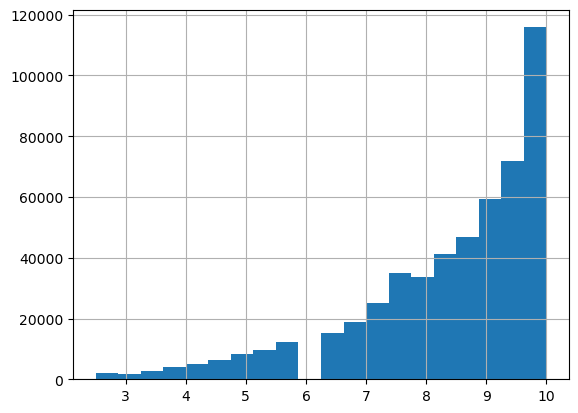

In [3]:
print(df['Reviewer_Score'].describe()) # show the statistics of the 'Reviewer_Score' column
# make a histogram of the 'Reviewer_Score' column
df['Reviewer_Score'].hist(bins=20) # 20 bins

# print the number of 10.0 scores 
print(df[df['Reviewer_Score'] == 10.0].shape[0])

print(df[df['Reviewer_Score'] == 6.0].shape[0])



Relevant columns are negative and positive reviews. We need to combine them to make it easier to work with the data.

# Cleaning the review text

In [4]:
# remove 'No Negative' and 'No Positive' from the reviews
df['Negative_Review'] = df['Negative_Review'].apply(lambda x: x.replace('No Negative', ''))
df['Positive_Review'] = df['Positive_Review'].apply(lambda x: x.replace('No Positive', ''))

# merge the two review columns into one
df['Review'] = df['Negative_Review'] + ' ' + df['Positive_Review']

df = df[[ 'Review','Reviewer_Score']] # select only the columns we need

# remove rows with missing values
df = df.dropna()

df.head() # show a overview of the data in the dataset

,Review,Reviewer_Score
0,I am so angry that i made this post available...,2.9
1,No real complaints the hotel was great great...,7.5
2,Rooms are nice but for elderly a bit difficul...,7.1
3,My room was dirty and I was afraid to walk ba...,3.8
4,You When I booked with your company on line y...,6.7


# Transforming review scores to binary values

In [5]:
# Adjust the reviewer score to be binary
df['Sentiment'] = df['Reviewer_Score'].apply(lambda x: 1 if x >= 7.0 else 0)
# Downsample the majority class (high review scores)
df_majority = df[df['Sentiment'] == 1]
df_minority = df[df['Sentiment'] == 0]

# Adjusting for sentiment imbalance
There is a heavy overweight of positive ('high' scores) in the dataset, so we need to downsample the positive reviews to get a more balanced dataset for our machine learning model to train and test on.

In [6]:
# Downsample majority class
df_majority_downsampled = df_majority.sample(len(df_minority))

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

df = df_balanced
df.head() # show a overview of the data in the dataset

,Review,Reviewer_Score,Sentiment
0,I did not realize I would get a room in the s...,9.2,1
1,Curtains broken cheap hairdryer no pool gym b...,5.0,0
2,Noisy WiFi costs facilities prices Comfy sta...,7.9,1
3,annoying system for the elevators too much in...,6.7,0
4,Near to my meeting points Friendly staff Ver...,5.4,0


# Preprocessing the review text

In [7]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['Review'] = df['Review'].apply(preprocess_text)
df.head()

,Review,Reviewer_Score,Sentiment
0,i did not realize i would get a room in the s...,9.2,1
1,curtains broken cheap hairdryer no pool gym b...,5.0,0
2,noisy wifi costs facilities prices comfy sta...,7.9,1
3,annoying system for the elevators too much in...,6.7,0
4,near to my meeting points friendly staff ver...,5.4,0


## Removing stopwords

In [8]:
import nltk

from nltk.corpus import stopwords
 
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
pattern = r'\b(' + '|'.join(re.escape(word) for word in stop_words) + r')\b'

def remove_stopwords_regex(text):
    if isinstance(text, str):  # Ensure it's a string
        return re.sub(pattern, '', text)  # Remove stop words
    return text

df["Review"] = df["Review"].apply(remove_stopwords_regex)
df["Review"] = df["Review"].str.replace(r'\s+', ' ', regex=True).str.strip()
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/runarrossevold/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Review,Reviewer_Score,Sentiment
0,realize would get room sous terrain matter day...,9.2,1
1,curtains broken cheap hairdryer pool gym balco...,5.0,0
2,noisy wifi costs facilities prices comfy staff...,7.9,1
3,annoying system elevators much information fil...,6.7,0
4,near meeting points friendly staff small rooms...,5.4,0


## Tokenization

In [9]:
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

def tokenize(text):
    return word_tokenize(text)

df['tokens'] = df['Review'].apply(tokenize)
df.head()


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/runarrossevold/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Review,Reviewer_Score,Sentiment,tokens
0,realize would get room sous terrain matter day...,9.2,1,"[realize, would, get, room, sous, terrain, mat..."
1,curtains broken cheap hairdryer pool gym balco...,5.0,0,"[curtains, broken, cheap, hairdryer, pool, gym..."
2,noisy wifi costs facilities prices comfy staff...,7.9,1,"[noisy, wifi, costs, facilities, prices, comfy..."
3,annoying system elevators much information fil...,6.7,0,"[annoying, system, elevators, much, informatio..."
4,near meeting points friendly staff small rooms...,5.4,0,"[near, meeting, points, friendly, staff, small..."


## Stemming

In [10]:
from nltk.stem import PorterStemmer

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

def stem(tokens):
    return [stemmer.stem(token) for token in tokens]

df['stemmed'] = df['tokens'].apply(stem)

df.head()

,Review,Reviewer_Score,Sentiment,tokens,stemmed
0,realize would get room sous terrain matter day...,9.2,1,"[realize, would, get, room, sous, terrain, mat...","[realiz, would, get, room, sou, terrain, matte..."
1,curtains broken cheap hairdryer pool gym balco...,5.0,0,"[curtains, broken, cheap, hairdryer, pool, gym...","[curtain, broken, cheap, hairdryer, pool, gym,..."
2,noisy wifi costs facilities prices comfy staff...,7.9,1,"[noisy, wifi, costs, facilities, prices, comfy...","[noisi, wifi, cost, facil, price, comfi, staff..."
3,annoying system elevators much information fil...,6.7,0,"[annoying, system, elevators, much, informatio...","[annoy, system, elev, much, inform, fill, chec..."
4,near meeting points friendly staff small rooms...,5.4,0,"[near, meeting, points, friendly, staff, small...","[near, meet, point, friendli, staff, small, ro..."


## Lemmatization

In [11]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')  # Download additional data for WordNet

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['lemmatized'] = df['tokens'].apply(lemmatize)

df.head()


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/runarrossevold/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/runarrossevold/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Review,Reviewer_Score,Sentiment,tokens,stemmed,lemmatized
0,realize would get room sous terrain matter day...,9.2,1,"[realize, would, get, room, sous, terrain, mat...","[realiz, would, get, room, sou, terrain, matte...","[realize, would, get, room, sou, terrain, matt..."
1,curtains broken cheap hairdryer pool gym balco...,5.0,0,"[curtains, broken, cheap, hairdryer, pool, gym...","[curtain, broken, cheap, hairdryer, pool, gym,...","[curtain, broken, cheap, hairdryer, pool, gym,..."
2,noisy wifi costs facilities prices comfy staff...,7.9,1,"[noisy, wifi, costs, facilities, prices, comfy...","[noisi, wifi, cost, facil, price, comfi, staff...","[noisy, wifi, cost, facility, price, comfy, st..."
3,annoying system elevators much information fil...,6.7,0,"[annoying, system, elevators, much, informatio...","[annoy, system, elev, much, inform, fill, chec...","[annoying, system, elevator, much, information..."
4,near meeting points friendly staff small rooms...,5.4,0,"[near, meeting, points, friendly, staff, small...","[near, meet, point, friendli, staff, small, ro...","[near, meeting, point, friendly, staff, small,..."


# Running MultionmialNB with TF-IDF vectorizer

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the text
X = vectorizer.fit_transform(df['Review'])

y = df['Sentiment']

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.naive_bayes import MultinomialNB

# Initialize Multinomial Naive Bayes classifier
mnb_tfidf = MultinomialNB()

# Train the model on the training data
mnb_tfidf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = mnb_tfidf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7928
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80     17371
           1       0.80      0.78      0.79     17370

    accuracy                           0.79     34741
   macro avg       0.79      0.79      0.79     34741
weighted avg       0.79      0.79      0.79     34741



# Running kNN 

Using k = 1000, as the default k=5 is too low for this dataset, and k=1000 gives better accuracy (0.75) than k=5 (0.58).

In [52]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1000)

# Train the kNN model on the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred_knn = knn.predict(X_test)

# Evaluate the kNN model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))


Accuracy: 0.7540
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.64      0.72     17371
           1       0.71      0.87      0.78     17370

    accuracy                           0.75     34741
   macro avg       0.77      0.75      0.75     34741
weighted avg       0.77      0.75      0.75     34741



## Finding best k

Trying to hyperparameter tune the k value for the kNN model. 
Having issues as the base algorithm with only one iteration takes 5 minutes to run. 
Low prospects for hyperparameter tuning.

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_neighbors': randint(1, 50)
}

# Initialize the RandomizedSearchCV with KNeighborsClassifier
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)

# Fit the random search model
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

# Make predictions on the test data using the best estimator
y_pred_random_search = random_search.best_estimator_.predict(X_test)

# Evaluate the model
accuracy_random_search = accuracy_score(y_test, y_pred_random_search)
print(f"Accuracy: {accuracy_random_search:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_random_search))


KeyboardInterrupt: 

# Comparing the algorithms

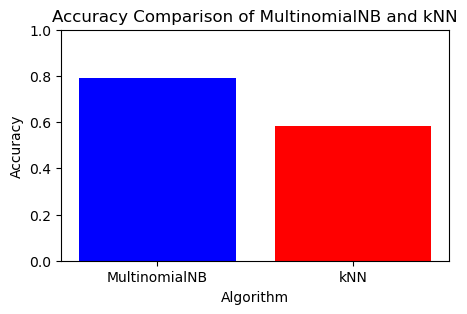

In [50]:
import matplotlib.pyplot as plt

# Create a bar plot to compare the accuracy of the algorithms
algorithms = ['MultinomialNB', 'kNN']
accuracies = [accuracy, accuracy_knn]

plt.figure(figsize=(5, 3))
plt.bar(algorithms, accuracies, color=['blue', 'red'])
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of MultinomialNB and kNN')
plt.ylim(0, 1)
plt.show()

# **TODO**

**Dataset exploration and preprocessing**
* find relevant columns
* check the datatypes of the columns - convert if needed
* check for missing values - handle missing values
* check for duplicate rows
* sjekke tekstlikhet (f.eks. nesten like setninger som kan være semantisk like).
* check data distribution (class imbalance, length of text, etc.)
  
**Clean the Text Data: - text preprocessing**
* lowercase text
* Remove Noise: special characters, numbers, punctuation, URLs, HTML tags, Emojis, extra whitespace, etc.
* Tokenization: Split text into words.
* Stopword removal
* Lemmatization/Stemming: gjøre begge men vise og skrive litt tekst ish: "stemming vises her men åpenbart er lemmatization bedre...:"

**Convert Text into Numerical Representation**
* Vectorization of the text - TFIDF greiene, bag of words osv
* prøv ulike måter
* Bag of Words (BoW): Convert text into a numerical representation using word frequency.
* TF-IDF (Term Frequency-Inverse Document Frequency): Weigh words based on their importance in the dataset.
* Word Embeddings: Use pre-trained models like Word2Vec, GloVe, or FastText for contextual meaning.

**Splitting Data for Training and Testing**
* Try different data splits (70/30) etc.

**Model Selection & Training**
* Prøv å justere parametre

**Evaluating models**
* Use multiple metrics, not just accuracy (e.g., F1-score, precision-recall)
* Confusion matrix analysis (to see misclassified examples)